<a href="https://colab.research.google.com/github/Saroramath/MachineLearning/blob/main/6205A/6205A4DenseNetWithDataAugAndDropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Goal

We will implement Densenet proposed in this [paper](https://arxiv.org/pdf/1608.06993.pdf) to train CIFAR10 Imageset

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as plt
from sklearn.model_selection import train_test_split
import math

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


> One hot encoding

In [3]:
y_train = tf.keras.utils.to_categorical(y_train,10)
y_test = tf.keras.utils.to_categorical(y_test,10)

# Densenet building blocks

## Composite function

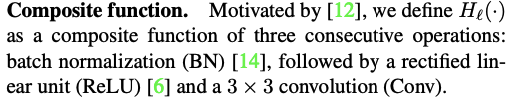

In [4]:
#Composite function
weight_decay=1e-4
def CompositeFunction(inp, filters, filter_size, d_rate):
  x = tf.keras.layers.BatchNormalization(gamma_regularizer=tf.keras.regularizers.l2(weight_decay))(inp)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Conv2D(filters, filter_size, padding='same')(x)
  x = tf.keras.layers.Dropout(d_rate)(x)
  return x  



## Dense Block

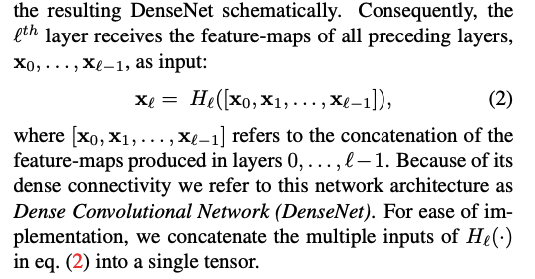

Let the input shape be $(32,32,k_0)$ on a Dense Block with $n$ number of layers and $k$ growth rate. Then the output shape will be $(32,32,k_0 + n.k)$
> Since we need to concatenate the result of each layer in DenseBlock, we don't change the image size by keeping padding as 'same' within a dense Block.

In [5]:
#DenseBlock
def DenseBlock(inp, num_layers,filters,d_rate, num_of_feature_maps):
  for i in range(num_layers):
    x = inp
    x = CompositeFunction(x, filters, (3,3), d_rate)
    inp = tf.keras.layers.Concatenate(axis=-1)([x,inp])
    num_of_feature_maps = num_of_feature_maps + growth_rate
  return inp, num_of_feature_maps

## Transition Block

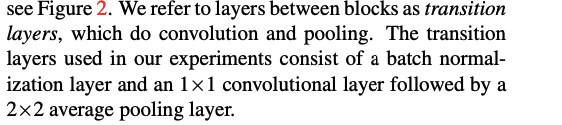

> The output of the denseblock is passed to a transition block, where we reduce the image size, in particular half it, $(16,16)$, so it can capture more details by using average pooling.

## Compression 
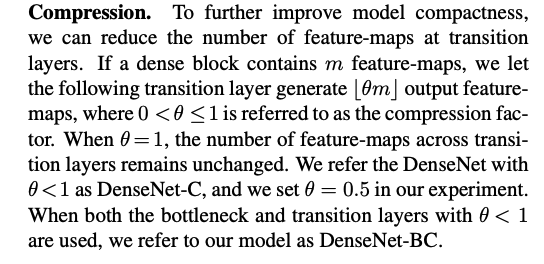

> Since the number of feature maps keep on increasing with DenseNet, we can use a compression factor to reduce them at each end. 

> If $\theta = 0.5$, the output shape after first transition layer will be $(16,16,\frac{k_0 + nk}{2})$

In [6]:
#TransitionBlock
def TransitionBlock(inputs, num_of_feature_maps, compression , d_rate ):
  num_of_feature_maps = math.floor(num_of_feature_maps*compression)
  x = CompositeFunction(inputs, num_of_feature_maps, (1,1), d_rate)
  out = tf.keras.layers.AveragePooling2D((2,2), strides=(2,2))(x)
  return out, num_of_feature_maps


# Model with Image augmentation and dropout

In [7]:
# Create the model

num_layers_in_blocks = [4,8,16]
growth_rate= 12
compression = 0.5
d_rate = 0.2
num_of_filters_in_first_layer = 16
num_of_feature_maps = num_of_filters_in_first_layer

inp = tf.keras.layers.Input(shape=(32,32,3))

x = tf.keras.layers.Conv2D(num_of_filters_in_first_layer,kernel_size=(3,3), use_bias=False, padding='same')(inp)

for i in range(len(num_layers_in_blocks)-1):
  x, num_of_feature_maps = DenseBlock(x, num_layers_in_blocks[i],growth_rate, d_rate, num_of_feature_maps)
  x, num_of_feature_maps = TransitionBlock(x, num_of_feature_maps, compression, d_rate)
x, num_of_feature_maps = DenseBlock(x, num_layers_in_blocks[-1],growth_rate, d_rate, num_of_feature_maps)




x = tf.keras.layers.GlobalAveragePooling2D()(x)
out = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.models.Model(inp, out)
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['acc', 'mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [8]:
image_aug = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2)

Batch_size = 64

xTrain, xVal, yTrain, yVal = train_test_split(x_train, y_train, test_size = 0.2)

img_gen = image_aug.flow(xTrain, yTrain, batch_size = Batch_size)


hist = model.fit(img_gen, epochs=100, batch_size=Batch_size, validation_data=(xVal, yVal))


Epoch 1/100
625/625 [==============================] - 72s 55ms/step - loss: 2.3002 - acc: 0.2906 - mse: 0.0824 - val_loss: 2.0210 - val_acc: 0.4179 - val_mse: 0.0752
Epoch 2/100
625/625 [==============================] - 31s 50ms/step - loss: 1.8068 - acc: 0.4383 - mse: 0.0692 - val_loss: 1.9334 - val_acc: 0.4690 - val_mse: 0.0693
Epoch 3/100
625/625 [==============================] - 31s 50ms/step - loss: 1.6213 - acc: 0.4953 - mse: 0.0641 - val_loss: 2.2027 - val_acc: 0.4678 - val_mse: 0.0749
Epoch 4/100
625/625 [==============================] - 31s 50ms/step - loss: 1.5006 - acc: 0.5257 - mse: 0.0607 - val_loss: 1.6500 - val_acc: 0.5198 - val_mse: 0.0640
Epoch 5/100
625/625 [==============================] - 31s 50ms/step - loss: 1.3876 - acc: 0.5579 - mse: 0.0574 - val_loss: 2.1710 - val_acc: 0.4291 - val_mse: 0.0806
Epoch 6/100
625/625 [==============================] - 32s 51ms/step - loss: 1.3315 - acc: 0.5698 - mse: 0.0557 - val_loss: 1.5709 - val_acc: 0.5676 - val_mse: 0.061

In [9]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.6069 - acc: 0.8166 - mse: 0.0266


[0.6069431900978088, 0.8166000247001648, 0.026622558012604713]